In [1]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd
import re
from datetime import datetime

# BPM class post mortem

In [2]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        return self._bpms_hor
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        return self._bpms_ver
    
    @property
    def hor_turn_position(self):
        if not hasattr(self, '_hor_pos'):
            self._build_hor_pos()
        return self._hor_pos
    
    @property
    def ver_turn_position(self):
        if not hasattr(self, '_ver_pos'):
            self._build_ver_pos()
        return self._ver_pos
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

    def _build_bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        self._bpms_hor = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    def _build_bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        self._bpms_ver = ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index

    def _build_hor_pos(self):
        if not hasattr(self, '_bpms_hor'):
            self._build_bpms_hor()
        self._hor_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_hor])
    
    def _build_ver_pos(self):
        if not hasattr(self, '_bpms_ver'):
            self._build_bpms_ver()
        self._ver_pos = ak.Array([self._full_index[bpm]['positions'] for bpm in self._bpms_ver])


ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

# Line

In [40]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [41]:
# correctors
all_corr_elems = tt.rows['mdh.*'].name
mask_corr = [not line[name].__class__.__name__.startswith('Limit') for name in all_corr_elems]
correctors = np.array(all_corr_elems)[mask_corr]

In [5]:
correctors

array(['mdh.10207', 'mdh.10407', 'mdh.10607', 'mdh.10807', 'mdh.11007',
       'mdh.11207', 'mdh.11407', 'mdh.11607', 'mdhw.11732', 'mdhw.11737',
       'mdhw.11738', 'mdhw.11754', 'mdh.11820', 'mdh.12007', 'mdh.12207',
       'mdh.12407', 'mdh.12607', 'mdh.12807', 'mdh.13007', 'mdh.13207',
       'mdh.13407', 'mdh.13607', 'mdh.20207', 'mdh.20407', 'mdh.20607',
       'mdh.20807', 'mdh.21007', 'mdh.21207', 'mdh.21407', 'mdha.21606',
       'mdha.21806', 'mdh.22007', 'mdh.22207', 'mdh.22407', 'mdh.22607',
       'mdh.22807', 'mdh.23007', 'mdh.23207', 'mdh.23407', 'mdh.23607',
       'mdh.30207', 'mdh.30407', 'mdh.30607', 'mdh.30807', 'mdh.31007',
       'mdh.31207', 'mdh.31407', 'mdh.31607', 'mdh.31807', 'mdh.32007',
       'mdh.32207', 'mdh.32407', 'mdh.32607', 'mdh.32807', 'mdh.33007',
       'mdh.33207', 'mdh.33407', 'mdh.33607', 'mdh.40207', 'mdh.40407',
       'mdh.40607', 'mdh.40807', 'mdh.41007', 'mdh.41207', 'mdh.41407',
       'mdh.41607', 'mdha.41804', 'mdh.42007', 'mdh.42207'

In [42]:
vary_list_names = []
for name in correctors:
    number = name.split('.')[1]
    if name.startswith('mdh.'):
        line[f'rdh.{number}'] = 0
        vary_list_names.append(f'rdh.{number}')
        line.ref[name].knl[0] += line.vars[f'rdh.{number}']
    else:
        line[f'rdh.{name.split('.')[0][-1]}.{number}'] = 0
        vary_list_names.append(f'rdh.{name.split('.')[0][-1]}.{number}')
        line.ref[name].knl[0] += line.vars[f'rdh.{name.split('.')[0][-1]}.{number}']

# MD reference orbit

In [10]:
path_orbit = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.18.44.00.711409.parquet')
bpm_orbit = ak.Array(ak.from_parquet(path_orbit), with_name='BPMCollection')

In [12]:
mask_bpm = np.array([True if bpm not in ['bph.10208', 'bph.31808', 'bph.63008', 'bph.63608', 'bph.62008', 'bph.11831'] else False for bpm in bpm_orbit.bpms_hor])
s_positions_bpms = np.array([line.get_s_position(f'{bpm}..0') for bpm in bpm_orbit.bpms_hor])

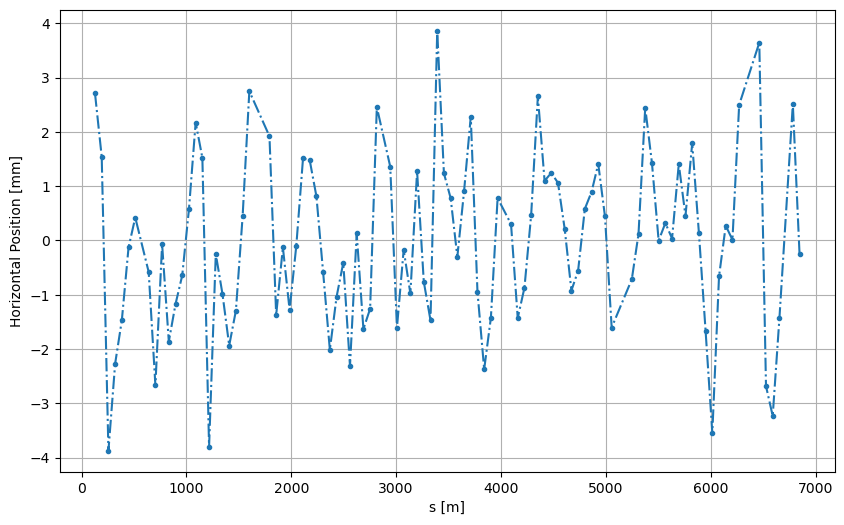

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], ak.mean(bpm_orbit.hor_turn_position[mask_bpm], axis=1), '.-.', label='Horizontal')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()

In [25]:
mean_orbit = ak.mean(bpm_orbit.hor_turn_position[mask_bpm], axis=1)

# Test matching

In [43]:
opt = line.match(
    solve=False,
    # start='mdh.11007',
    # end='mdhw.11732',
    init=tw_ref,
    vary=[
        xt.VaryList(vary_list_names, step=1e-10, tag='correctors',)
    ],
    targets = [
        # xt.Target('x', -10e-3, at='tidp.11434'),
        # xt.TargetSet(['x', 'px'], value=tw_ref, at='mdhw.11732')
    
        xt.TargetSet(['x'], value = val, at=f'{bpm_name}..1') for bpm_name, val in zip(bpm_orbit.bpms_hor[mask_bpm], mean_orbit * 1e-3)
    ]
    )
opt.run_jacobian(10)

                                             
Optimize - start penalty: 0.1591                            
Matching: model call n. 235 penalty = 1.9017e-08              
Optimize - end penalty:  1.90165e-08                            


In [44]:
tw = line.twiss()

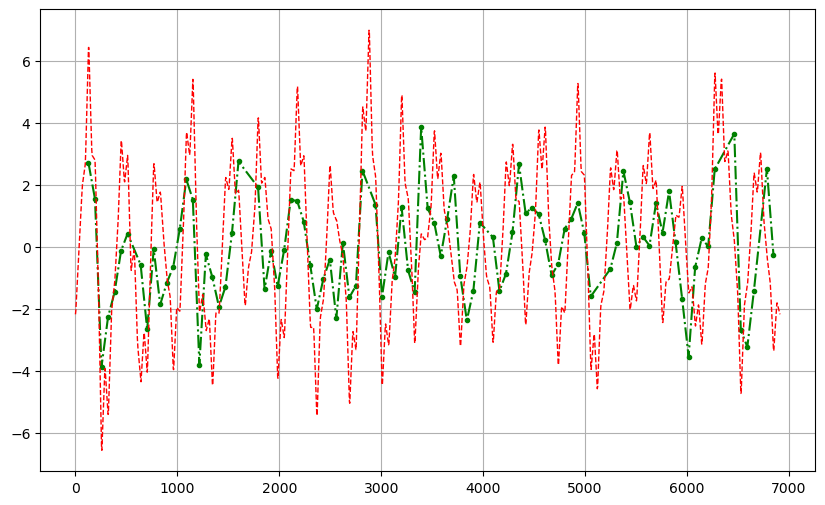

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], mean_orbit, '.-.', color='green', label='MD data')
ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
ax.grid()

## Test with only used correctors in MD

In [46]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [47]:
correctors = []
vary_list_names = []

# line['rdh.21007'] = 0
# line['rdh.22207'] = 0
# line['rdh.22407'] = 0
# line['rdh.22607'] = 0
# line['rdh.30207'] = 0
# line['rdh.31207'] = 0
# line['rdh.33607'] = 0
# line['rdh.40407'] = 0
# line['rdh.41607'] = 0
# line['rdh.42007'] = 0
# line['rdh.42407'] = 0
# line['rdh.51007'] = 0
# line['rdh.51207'] = 0
# line['rdh.52607'] = 0
# line['rdha.61805'] = 0

numbers = sorted([40407, 31207, 61805, 33607, 22607, 22207, 22407, 21007,
           52607, 42407, 51207, 51007, 30207, 42007, 41607])

for number in numbers:
    if number == 61805:
        line[f'rdha.{number}'] = 0
        vary_list_names.append(f'rdha.{number}')
        correctors.append(f'mdha.{number}')
        line.ref[f'mdha.{number}'].knl[0] += line.vars[f'rdha.{number}']
    else:
        line[f'rdh.{number}'] = 0
        vary_list_names.append(f'rdh.{number}')
        correctors.append(f'mdh.{number}')
        line.ref[f'mdh.{number}'].knl[0] += line.vars[f'rdh.{number}']

In [48]:
opt = line.match(
    solve=False,
    # start='mdh.11007',
    # end='mdhw.11732',
    init=tw_ref,
    vary=[
        xt.VaryList(vary_list_names, step=1e-8, tag='correctors',)
    ],
    targets = [
        # xt.Target('x', -10e-3, at='tidp.11434'),
        # xt.TargetSet(['x', 'px'], value=tw_ref, at='mdhw.11732')
    
        xt.TargetSet(['x'], value = val, at=f'{bpm_name}..1') for bpm_name, val in zip(bpm_orbit.bpms_hor[mask_bpm], mean_orbit * 1e-3)
    ]
    )
opt.run_jacobian(10)

                                             
Optimize - start penalty: 0.1591                            
Matching: model call n. 185 penalty = 1.3834e-01              
Optimize - end penalty:  0.138341                            


In [49]:
tw = line.twiss()

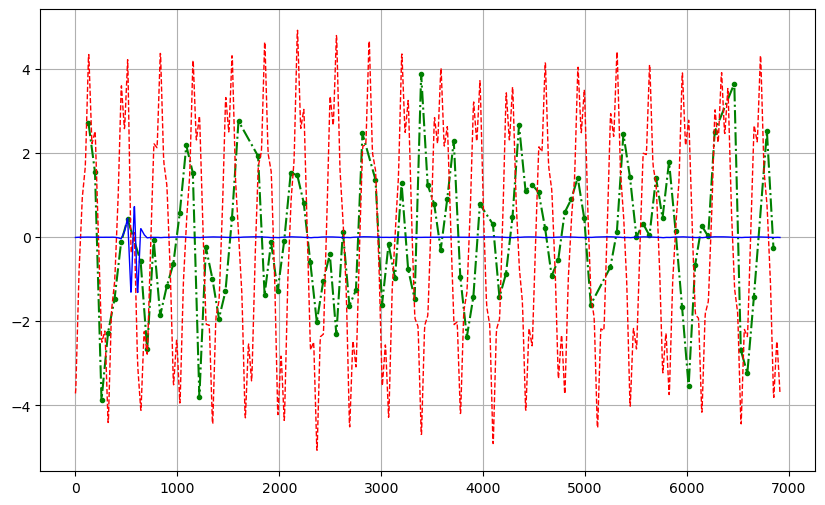

In [75]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], mean_orbit, '.-.', color='green', label='MD data')
ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
ax.plot(tw_ref.s, tw_ref.x * 1e3, '-', lw=1, color='blue', label='Reference Twiss')
ax.grid()

# Test with narrowing down the correctors for each bpm

In [51]:
bpm_orbit.bpms_hor[mask_bpm]

<Array ['bph.10408', 'bph.10608', ..., 'bph.63408'] type='96 * string'>

In [52]:
# correctors
all_corr_elems = tt.rows['mdh.*'].name
mask_corr = [not line[name].__class__.__name__.startswith('Limit') for name in all_corr_elems]
correctors = np.array(all_corr_elems)[mask_corr]

In [53]:
correctors

array(['mdh.10207', 'mdh.10407', 'mdh.10607', 'mdh.10807', 'mdh.11007',
       'mdh.11207', 'mdh.11407', 'mdh.11607', 'mdhw.11732', 'mdhw.11737',
       'mdhw.11738', 'mdhw.11754', 'mdh.11820', 'mdh.12007', 'mdh.12207',
       'mdh.12407', 'mdh.12607', 'mdh.12807', 'mdh.13007', 'mdh.13207',
       'mdh.13407', 'mdh.13607', 'mdh.20207', 'mdh.20407', 'mdh.20607',
       'mdh.20807', 'mdh.21007', 'mdh.21207', 'mdh.21407', 'mdha.21606',
       'mdha.21806', 'mdh.22007', 'mdh.22207', 'mdh.22407', 'mdh.22607',
       'mdh.22807', 'mdh.23007', 'mdh.23207', 'mdh.23407', 'mdh.23607',
       'mdh.30207', 'mdh.30407', 'mdh.30607', 'mdh.30807', 'mdh.31007',
       'mdh.31207', 'mdh.31407', 'mdh.31607', 'mdh.31807', 'mdh.32007',
       'mdh.32207', 'mdh.32407', 'mdh.32607', 'mdh.32807', 'mdh.33007',
       'mdh.33207', 'mdh.33407', 'mdh.33607', 'mdh.40207', 'mdh.40407',
       'mdh.40607', 'mdh.40807', 'mdh.41007', 'mdh.41207', 'mdh.41407',
       'mdh.41607', 'mdha.41804', 'mdh.42007', 'mdh.42207'

# Matching locally

In [ ]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [ ]:
qf_names = tt.rows['qf.*'].name
qd_names = tt.rows['qd.*'].name
qf_numbers = [name.split('.')[1] for name in qf_names]
qd_numbers = [name.split('.')[1] for name in qd_names]

bpm_name_elements = [f'{name}..1' for name in bpm_orbit.bpms_hor[mask_bpm]]
bpm_vals = ak.to_numpy(mean_orbit * 1e-3)

In [ ]:
qd_names

array(['qd.10110', 'qd.10310', 'qd.10510', 'qd.10710', 'qd.10910',
       'qd.11110', 'qd.11310', 'qd.11510', 'qd.11710', 'qda.11910',
       'qd.12110', 'qd.12310', 'qd.12510', 'qd.12710', 'qd.12910',
       'qd.13110', 'qd.13310', 'qd.13510', 'qd.20110', 'qd.20310',
       'qd.20510', 'qd.20710', 'qd.20910', 'qd.21110', 'qd.21310',
       'qd.21510', 'qda.21710', 'qda.21910', 'qd.22110', 'qd.22310',
       'qd.22510', 'qd.22710', 'qd.22910', 'qd.23110', 'qd.23310',
       'qd.23510', 'qd.30110', 'qd.30310', 'qd.30510', 'qd.30710',
       'qd.30910', 'qd.31110', 'qd.31310', 'qd.31510', 'qd.31710',
       'qd.31910', 'qd.32110', 'qd.32310', 'qd.32510', 'qd.32710',
       'qd.32910', 'qd.33110', 'qd.33310', 'qd.33510', 'qd.40110',
       'qd.40310', 'qd.40510', 'qd.40710', 'qd.40910', 'qd.41110',
       'qd.41310', 'qd.41510', 'qda.41710', 'qda.41910', 'qd.42110',
       'qd.42310', 'qd.42510', 'qd.42710', 'qd.42910', 'qd.43110',
       'qd.43310', 'qd.43510', 'qd.50110', 'qd.50310', 'q

In [ ]:
def get_surrounding_quads(bpm_name, qf_numbers, qd_numbers, qd_names, qf_names):
    bpm_number = bpm_name.split('.')[1]
    bpm_number = int(bpm_number)
    
    # Find the closest QF and QD quads
    closest_qf = min(qf_numbers, key=lambda x: abs(int(x) - bpm_number))
    closest_qd = min(qd_numbers, key=lambda x: abs(int(x) - bpm_number))

    idx_qf = qf_numbers.index(closest_qf)
    idx_qd = qd_numbers.index(closest_qd)
    
    # Get the names of the closest quads
    qf_name = qf_names[idx_qf]
    qd_name = qd_names[idx_qd]

    return closest_qd, closest_qf, qd_name, qf_name

                                             
Optimize - start penalty: 0.02712                           
Matching: model call n. 9 penalty = 1.6480e-16              
Optimize - end penalty:  1.64799e-16                            
                                             
Optimize - start penalty: 0.03498                           
Matching: model call n. 78 penalty = 3.4965e-02              
Optimize - end penalty:  0.0349651                            
                                             
Optimize - start penalty: 0.01247                           
Matching: model call n. 74 penalty = 1.2007e-03              
Optimize - end penalty:  0.00120074                            
                                             
Optimize - start penalty: 0.03249                           
Matching: model call n. 74 penalty = 1.6144e-02              
Optimize - end penalty:  0.0161439                            
                                             
Optimize - start penalty

ClosedOrbitSearchError: 

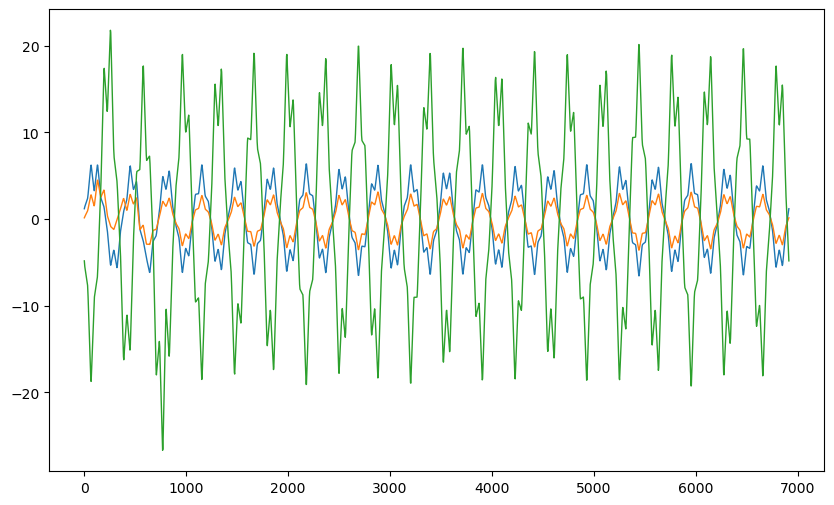

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
for i, bpm_name in enumerate(bpm_orbit.bpms_hor[mask_bpm]):
    if i > 0:
        prev = f'{bpm_orbit.bpms_hor[mask_bpm][i - 1]}..1'
    else:
        prev = 'qd.10310'
    if i < 20:
        tw_ref = line.twiss()
        qd_number, qf_number, qd_name, qf_name = get_surrounding_quads(bpm_name, qf_numbers, qd_numbers, qd_names, qf_names)

        vary_list_loc = []
        line[f'kqd.{qd_number}'] = 0
        vary_list_loc.append(f'kqd.{qd_number}')
        line[f'kqf.{qf_number}'] = 0
        vary_list_loc.append(f'kqf.{qf_number}')
        line.ref[qd_name].knl[0] += line.vars[f'kqd.{qd_number}']
        line.ref[qf_name].knl[0] += line.vars[f'kqf.{qf_number}']

        if i > 0 :
            opt = line.match(
                solve=False,
                init = tw_ref,
                start=prev,
                end=qf_name,
                vary = [
                    xt.VaryList(vary_list_loc, step=1e-8, tag=f'corr_{bpm_name}')
                ],
                targets = [
                    xt.Target('x', bpm_vals[i], at=f'{bpm_name}..1'),
                    xt.TargetSet(['x'], value=bpm_vals[i-1], at=prev)
                ]
            )
        else:
            opt = line.match(
                solve=False,
                init = tw_ref,
                start=prev,
                end=qf_name,
                vary = [
                    xt.VaryList(vary_list_loc, step=1e-8, tag=f'corr_{bpm_name}')
                ],
                targets = [
                    xt.Target('x', bpm_vals[i], at=f'{bpm_name}..1')
                ]
            )
        opt.run_jacobian(10)
        tw = line.twiss()
        if i%5 == 0:ax.plot(tw.s, tw.x * 1e3, lw=1, label=f'{bpm_name}')
ax.legend()

In [ ]:
bpm_orbit.bpms_hor

<Array ['bph.10208', 'bph.10408', ..., 'bph.63608'] type='102 * string'>

In [ ]:
tt.rows['bph.10408.*']

Table: 5 rows, 11 cols
name                         s element_type isthick isreplica parent_name iscollective ...
bph.10408..0           127.621 DriftSlice      True     False bph.10408          False
bph.10408.a_aper       127.621 LimitRect      False     False None               False
bph.10408..1           127.621 DriftSlice      True     False bph.10408          False
bph.10408.b_aper       127.895 LimitRect      False     False None               False
bph.10408..2           127.895 DriftSlice      True     False bph.10408          False

In [ ]:
get_surrounding_quads(bpm_name_elements[0], qf_numbers, qd_numbers)

('qf.10410', 'qd.10310')

In [ ]:
tt.rows['qd.11910.*']

Table: 0 rows, 11 cols

In [ ]:
bpm_name_elements[0]

'bph.10408..1'

In [ ]:
opt = line.match(
    solve=False,
    # start='mdh.11007',
    # end='mdhw.11732',
    init=tw_ref,
    vary=[
        xt.VaryList(vary_list_names, step=1e-8, tag='correctors',)
    ],
    targets = [
        # xt.Target('x', -10e-3, at='tidp.11434'),
        # xt.TargetSet(['x', 'px'], value=tw_ref, at='mdhw.11732')
    
        xt.TargetSet(['x'], value = val, at=f'{bpm_name}..1') for bpm_name, val in zip(bpm_orbit.bpms_hor[mask_bpm], mean_orbit * 1e-3)
    ]
    )
opt.run_jacobian(10)

# Test Dora function

In [272]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [273]:
def build_response_matrix(tw, monitor_names, corrector_names, plane=None):

    assert plane in ['x', 'y']

    # Build response matrix
    indices_monitors = tw.rows.indices[monitor_names]
    indices_correctors = tw.rows.indices[corrector_names]
    bet_monitors = tw['bet' + plane][indices_monitors]
    bet_correctors = tw['bet' + plane][indices_correctors]

    mu_monitor = tw['mu' + plane][indices_monitors]
    mux_correctors = tw['mu' + plane][indices_correctors]

    n_monitors = len(monitor_names)
    n_correctors = len(corrector_names)

    bet_prod = np.atleast_2d(bet_monitors).T @ np.atleast_2d(bet_correctors)
    mu_diff = (np.tile(mu_monitor, (n_correctors, 1)).T
                        - np.tile(mux_correctors, (n_monitors, 1)))

    # Slide 28
    # https://indico.cern.ch/event/1328128/contributions/5589794/attachments/2786478/4858384/linearimperfections_2024.pdf
    tune = tw['q' + plane]
    response_matrix = (np.sqrt(bet_prod) / 2 / np.sin(np.pi * tune)
                            * np.cos(np.pi * tune - 2*np.pi*np.abs(mu_diff)))

    return response_matrix

# """
#     Construct response matrix
#     """
#     response_matrix_H = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_H, 
#         corrector_names=errors_H, 
#         plane='x')
#     response_matrix_V = build_response_matrix(
#         tw=tw_ref, 
#         monitor_names=target_at_V, 
#         corrector_names=errors_V, 
#         plane='y')
    

#     """
#     Calculate necessary errors
#     """
#     U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
#     threshold_H = 1e-3 * np.max(sigma_H)
#     sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
#     M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
#     k_H = M_pseudo_inv_H @ target_val_H

#     U_V, sigma_V, VT_V = np.linalg.svd(response_matrix_V, full_matrices=False)
#     threshold_V = 1e-4 * np.max(sigma_V)
#     sigma_inv_V = np.array([1/s if s > threshold_V else 0 for s in sigma_V])
#     M_pseudo_inv_V = VT_V.T @ np.diag(sigma_inv_V) @ U_V.T
#     k_V = M_pseudo_inv_V @ target_val_V


In [274]:
error_locs_H = []
for i in range(len(line.element_names)):
    name = line.element_names[i]
    if name.startswith("qf."):
        error_locs_H.append(name)

In [275]:
line.discard_tracker()

for i in range(len(error_locs_H)):
    print("Adding H error", i+1, "out of", len(error_locs_H))

    error_loc_name = re.split(r"[._]", error_locs_H[i])
    knl_name = "knl_err_" + error_loc_name[0] + error_loc_name[1]
    errname = "errH_" + error_loc_name[0] + error_loc_name[1]

    line.vars[knl_name] = 0.0

    curr_multipole_error = xt.Multipole(knl=[0.0], ksl=[0.0])
    curr_idx = np.where(np.asarray(line.element_names) == error_locs_H[i])[0][0] + 1
    line.insert_element(element=curr_multipole_error, name=errname, at=curr_idx)

    line.element_refs[errname].knl[0] = line.vars[knl_name]

Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H error 34 out of 102
Adding H error 35 out o

In [276]:
line.build_tracker()

In [277]:
errors_H = []
for name in line.element_names:
    if "errH" in name:
        errors_H.append(name)

In [278]:
tw_ref = line.twiss()

In [279]:
response_matrix_H = build_response_matrix(
        tw=tw_ref, 
        monitor_names=[f'{name}..1' for name in bpm_orbit.bpms_hor[mask_bpm]], 
        corrector_names=errors_H, 
        plane='x')

In [ ]:
U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
threshold_H = 1e-3 * np.max(sigma_H)
sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
k_H = M_pseudo_inv_H @ ak.to_numpy(mean_orbit*1e-3)

In [281]:
vary_H = []
for var_name in line.vars.keys():
    if "knl_err" in var_name:
        vary_H.append(var_name)

In [282]:
for i in range(len(vary_H)):
    line.vv[vary_H[i]] = k_H[i] * -1

In [283]:
tw = line.twiss()

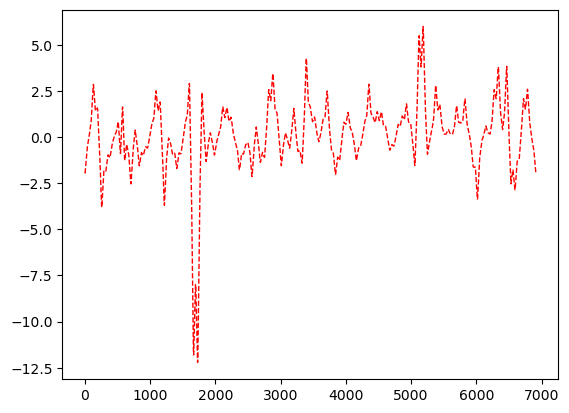

In [284]:
plt.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')

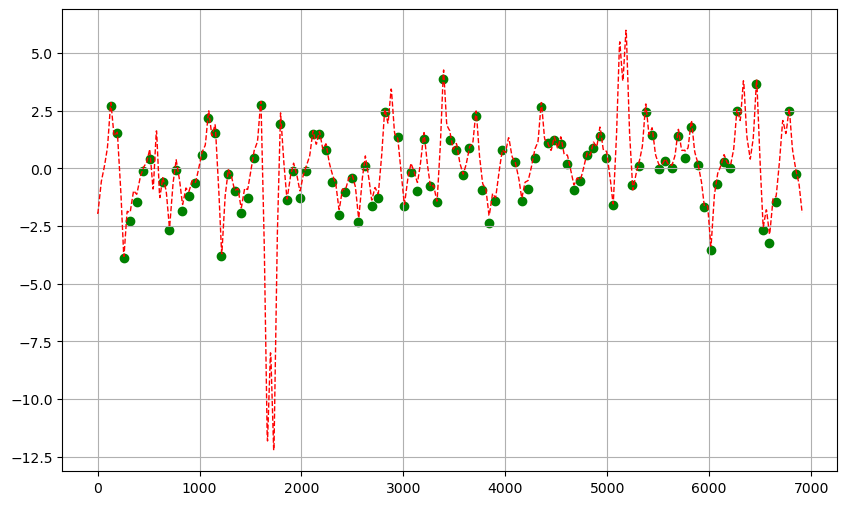

In [285]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(s_positions_bpms[mask_bpm], mean_orbit, color='green', label='MD data')
ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
ax.grid()

In [286]:
line.to_json('../injection_lines/sps_orbit_md_20250616.json')

## Line with other treshold to get rid of the spikes

In [621]:
line = xt.Line.from_json('../injection_lines/sps_with_aperture_inj_q20_beam_sagitta5.json')
tt = line.get_table()
tw_ref = line.twiss()

Loading line from dict:   0%|          | 0/36404 [00:00<?, ?it/s]

Done loading line from dict.           


In [622]:
error_locs_H = []
for i in range(len(line.element_names)):
    name = line.element_names[i]
    if name.startswith("qf."):
        error_locs_H.append(name)

In [623]:
line.discard_tracker()

for i in range(len(error_locs_H)):
    print("Adding H error", i+1, "out of", len(error_locs_H))

    error_loc_name = re.split(r"[._]", error_locs_H[i])
    knl_name = "knl_err_" + error_loc_name[0] + error_loc_name[1]
    errname = "errH_" + error_loc_name[0] + error_loc_name[1]

    line.vars[knl_name] = 0.0

    curr_multipole_error = xt.Multipole(knl=[0.0], ksl=[0.0])
    curr_idx = np.where(np.asarray(line.element_names) == error_locs_H[i])[0][0] + 1
    line.insert_element(element=curr_multipole_error, name=errname, at=curr_idx)

    line.element_refs[errname].knl[0] = line.vars[knl_name]

Adding H error 1 out of 102
Adding H error 2 out of 102
Adding H error 3 out of 102
Adding H error 4 out of 102
Adding H error 5 out of 102
Adding H error 6 out of 102
Adding H error 7 out of 102
Adding H error 8 out of 102
Adding H error 9 out of 102
Adding H error 10 out of 102
Adding H error 11 out of 102
Adding H error 12 out of 102
Adding H error 13 out of 102
Adding H error 14 out of 102
Adding H error 15 out of 102
Adding H error 16 out of 102
Adding H error 17 out of 102
Adding H error 18 out of 102
Adding H error 19 out of 102
Adding H error 20 out of 102
Adding H error 21 out of 102
Adding H error 22 out of 102
Adding H error 23 out of 102
Adding H error 24 out of 102
Adding H error 25 out of 102
Adding H error 26 out of 102
Adding H error 27 out of 102
Adding H error 28 out of 102
Adding H error 29 out of 102
Adding H error 30 out of 102
Adding H error 31 out of 102
Adding H error 32 out of 102
Adding H error 33 out of 102
Adding H error 34 out of 102
Adding H error 35 out o

In [624]:
line.build_tracker()

In [625]:
errors_H = []
for name in line.element_names:
    if "errH" in name:
        errors_H.append(name)

In [626]:
tw_ref = line.twiss()

In [627]:
response_matrix_H = build_response_matrix(
        tw=tw_ref, 
        monitor_names=[f'{name}..1' for name in bpm_orbit.bpms_hor[mask_bpm]], 
        corrector_names=errors_H, 
        plane='x')

In [628]:
U_H, sigma_H, VT_H = np.linalg.svd(response_matrix_H, full_matrices=False)
threshold_H = 5e-3 * np.max(sigma_H)
sigma_inv_H = np.array([1/s if s > threshold_H else 0 for s in sigma_H])
M_pseudo_inv_H = VT_H.T @ np.diag(sigma_inv_H) @ U_H.T
k_H = M_pseudo_inv_H @ ak.to_numpy(mean_orbit*1e-3)

In [629]:
vary_H = []
for var_name in line.vars.keys():
    if "knl_err" in var_name:
        vary_H.append(var_name)

In [630]:
for i in range(len(vary_H)):
    line.vv[vary_H[i]] = k_H[i] * -1

tw = line.twiss()

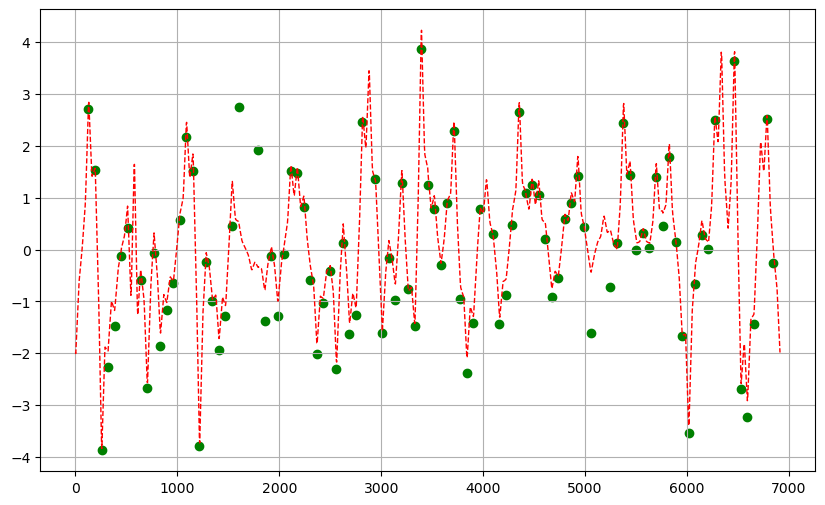

In [631]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(s_positions_bpms[mask_bpm], mean_orbit, color='green', label='MD data')
ax.plot(tw.s, tw.x * 1e3, '--', lw=1, color='red', label='Twiss')
ax.grid()

In [632]:
line.to_json('../injection_lines/sps_orbit_md_20250616_v2.json')

# Testing radial steering

## Particle on closed orbit

In [484]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05
tw_before_with_bump = line.twiss()

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


In [485]:
def get_straight_line(t, t1, r1, t2, r2):
    alpha = (r2 - r1) / (t2 - t1)
    return r1 + alpha * (t - t1)

In [486]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 10
plane = 'DPneg'
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
sweep = delta_emp * cav[0].frequency * tw_ref.slip_factor *0.9
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 7000

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [487]:
# Insert monitors as bpms
tt = line.get_table()
bph_list = tt.rows['bph.*..0'].name
env = line.env
insertions = []
monitors_elems = []
for name in bph_list:
    monitors_elems.append(xt.ParticlesMonitor(_context=line._context, 
                                                          num_particles=num_particles, 
                                                          start_at_turn=0, 
                                                          stop_at_turn=num_turns+1))
    env.elements[f'{name}_monitor'] = monitors_elems[-1]
    insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

In [488]:
#Installing TIDP
tidp_ap_tot = 147e-3
block_mvt = 29e-3

line.discard_tracker()
tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
line.collimators.install(names=['tidp.11434'], elements=[tidp])

tw = line.twiss()

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

In [489]:
part = xt.Particles(
    x = np.ones(num_particles) * tw.particle_on_co.x[0], #np.ones(N_part) * tw.particle_on_co.x[0], #np.linspace(-40e-3, 40e-3, N_part),
    px = np.ones(num_particles) * tw.particle_on_co.px[0],
    y = np.ones(num_particles) * tw.particle_on_co.y[0],
    py = np.ones(num_particles) * tw.particle_on_co.py[0],
    delta = np.ones(num_particles) * tw.particle_on_co.delta[0],#np.linspace(-5e-3, 5e-3, N_part), #np.ones(N_part) * tw.particle_on_co.delta[0],
    zeta = np.ones(num_particles) * tw.particle_on_co.zeta[0],
    p0c = np.ones(num_particles) * tw.particle_on_co.p0c[0],
)
# part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
#                                           nemitt_y=2e-6,
#                                           sigma_z=0.224, num_particles=num_particles, line=line)

In [490]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

res = []
line.scattering.enable()
# for turn in range(num_turns):
#     if np.unique(part.state) > 0:
#         rf_sweep.track(sweep=sweep/num_turns, particles=part, num_turns=1, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
#         res.append(line.record_last_track.x[0])
#     else:
#         break

rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 0.31188237080584247Hz per turn until 200002183.17659563 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.0061424485927865395 (-0.9494525116593155 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

In [491]:
turn_max = part.at_turn[0]
tt = line.get_table()
monitors = tt.rows['.*monitor.*'].name
s_positions_monitors = tt.rows['.*monitor.*'].s
x_positions = []

data_mean = {}
for i, monitor in enumerate(monitors):
    masked_x = ak.Array([monitors_elems[i].x[p][monitors_elems[i].state[p] > 0] for p in range(len(monitors_elems[i].x))])
    data_mean[monitor] = ak.mean(masked_x, axis=0)

for turn in range(turn_max):
    x_turn = []
    for monitor in monitors:
        x_turn.append(data_mean[monitor][turn])
    x_positions.append(x_turn)

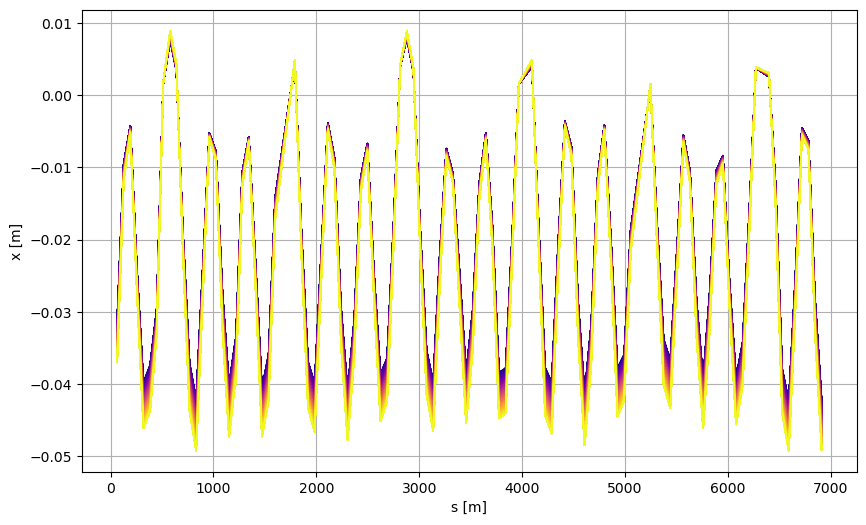

In [492]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')
counter = 0
for i, x_turn in enumerate(x_positions):
    if i > len(x_positions) - 1024:
        ax.plot(s_positions_monitors, x_turn, label='Turn {}'.format(i), color=cmap(counter / 1024), linewidth=1)
        counter +=1
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()

## Gaussian bunch with a few particles

In [445]:
line = xt.Line.from_json('../injection_lines/sps_orbit_md_20250616.json')
tw_ref = line.twiss()
cav, _ = line.get_elements_of_type(xt.Cavity)
line['bump.11207'] = 1.19603e-4
line['bump.11407'] = -9.3027e-5
line['bump.11607'] = 1.19603e-4

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']


line.vars['qph_setvalue'] = 0.5
line.vars['qpv_setvalue'] = 0.5
line.vars['qh_setvalue'] = line.vars['qx0']._value + 0.05
line.vars['qv_setvalue'] = line.vars['qy0']._value + 0.05
tw_before_with_bump = line.twiss()

Loading line from dict:   0%|          | 0/36506 [00:00<?, ?it/s]

Done loading line from dict.           


In [446]:
def get_straight_line(t, t1, r1, t2, r2):
    alpha = (r2 - r1) / (t2 - t1)
    return r1 + alpha * (t - t1)

In [447]:
#Context and parameters
context = xo.ContextCpu()

num_particles  = 10
plane = 'DPneg'
delta_emp = 0.307*get_straight_line(1.967, 1.027,0, 1.967, -22e-3)
sweep = delta_emp * cav[0].frequency * tw_ref.slip_factor
sweep = -abs(sweep) if plane == 'DPpos' else abs(sweep)
num_turns = 7000

#Setting cavities to the same frequency and phase, plus setting the voltage
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
line['acl.31735'].voltage = 0 #setting 800 cav to 0V
line['actcse.31632'].voltage = 3.5e6

In [448]:
# Insert monitors as bpms
tt = line.get_table()
bph_list = tt.rows['bph.*..0'].name
env = line.env
insertions = []
monitors_elems = []
for name in bph_list:
    monitors_elems.append(xt.ParticlesMonitor(_context=line._context, 
                                                          num_particles=num_particles, 
                                                          start_at_turn=0, 
                                                          stop_at_turn=num_turns+1))
    env.elements[f'{name}_monitor'] = monitors_elems[-1]
    insertions.append(env.place(f'{name}_monitor', at=line.get_s_position(name)))
line.insert(insertions, s_tol=1e-6)

Slicing line:   0%|          | 0/33114 [00:00<?, ?it/s]

In [449]:
#Installing TIDP
tidp_ap_tot = 147e-3
block_mvt = 29e-3

line.discard_tracker()
tidp = xc.EverestCollimator(length=4.3, material=xc.materials.Carbon, jaw_L= tidp_ap_tot/2 + block_mvt, jaw_R = -tidp_ap_tot/2 + block_mvt)
line.collimators.install(names=['tidp.11434'], elements=[tidp])

tw = line.twiss()

Slicing line:   0%|          | 0/33218 [00:00<?, ?it/s]

In [450]:
part = xp.generate_matched_gaussian_bunch(nemitt_x=2e-6,
                                          nemitt_y=2e-6,
                                          sigma_z=0.224, num_particles=num_particles, line=line)

*** Maximum RMS bunch length 0.23610110213554214m.
... distance to target bunch length: -2.2226e-01
... distance to target bunch length: 5.5784e-03
... distance to target bunch length: 5.2361e-03
... distance to target bunch length: -6.3267e-03
... distance to target bunch length: 1.9948e-03
... distance to target bunch length: -3.8258e-04
... distance to target bunch length: 5.3833e-05
... distance to target bunch length: 1.2594e-06
... distance to target bunch length: -1.0995e-10
... distance to target bunch length: 1.2805e-07
--> Bunch length: 0.2239999998900487
--> Emittance: 0.30344800513407316


In [451]:
rf_sweep = xc.RFSweep(line)
rf_sweep.info(sweep=sweep, num_turns=num_turns)

res = []
line.scattering.enable()
# for turn in range(num_turns):
#     if np.unique(part.state) > 0:
#         rf_sweep.track(sweep=sweep/num_turns, particles=part, num_turns=1, time=True, turn_by_turn_monitor='ONE_TURN_EBE')
#         res.append(line.record_last_track.x[0])
#     else:
#         break

rf_sweep.track(sweep=sweep, particles=part, num_turns=num_turns, time=True, with_progress=True)
line.scattering.disable()

The current frequency is 200000000.0Hz, adding 0.3465359675620472Hz per turn until 200002425.75177294 (for 7000 turns).
This sweep will move the center of the bucket with Δδ = -0.006824942880873933 (-1.0549472351770173 buckets).


Tracking:   0%|          | 0/7000 [00:00<?, ?it/s]

All particles lost at turn 6810, stopped sweep at 2336.345508Hz.


In [ ]:
turn_max = part.at_turn[0]
tt = line.get_table()
monitors = tt.rows['.*monitor.*'].name
s_positions_monitors = tt.rows['.*monitor.*'].s
x_positions = []

data_mean = {}
for i, monitor in enumerate(monitors):
    masked_x = ak.Array([monitors_elems[i].x[p][monitors_elems[i].state[p] > 0] for p in range(len(monitors_elems[i].x))])
    data_mean[monitor] = ak.mean(masked_x, axis=0)

for turn in range(turn_max):
    x_turn = []
    for monitor in monitors:
        x_turn.append(data_mean[monitor][turn])
    x_positions.append(x_turn)
x_positions = ak.Array(x_positions)

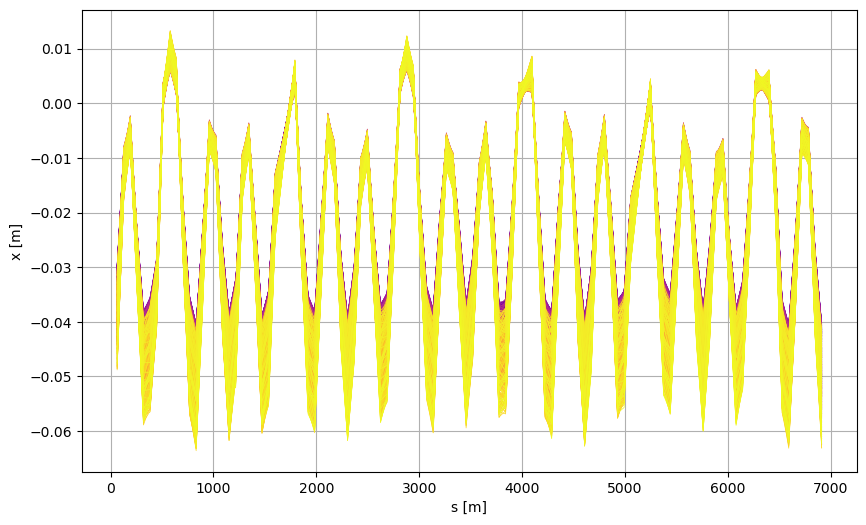

In [453]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
cmap = plt.get_cmap('plasma')
counter = 0
for i, x_turn in enumerate(x_positions):
    if i >len(x_positions) - 1024:
        ax.plot(s_positions_monitors, x_turn, label='Turn {}'.format(i), color=cmap(counter / 1024), linewidth=0.5)
        counter +=1
ax.set_xlabel('s [m]')
ax.set_ylabel('x [m]')
ax.grid()

In [371]:
len(x_turn)

104

In [375]:
masked_x

<Array [[-0.0085, -0.00886, ..., -0.0581], ..., [...]] type='5 * var * float64'>

In [379]:
len(x_turn)

104

# Comparing xsuite vs data

I will compare the last turn...

In [456]:
path_data = Path('/Users/lisepauwels/sps_simulations/MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.20.04.15.339607.parquet')
md_data = ak.Array(ak.from_parquet(path_data), with_name='BPMCollection')

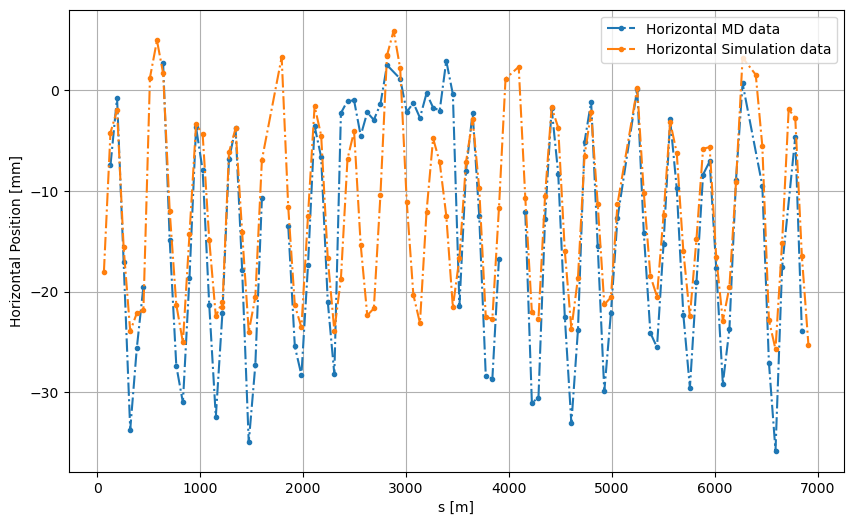

In [494]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], ak.mean(md_data.hor_turn_position[mask_bpm], axis=1), '.-.', label='Horizontal MD data')
ax.plot(s_positions_monitors, ak.mean(ak.Array(x_positions), axis=0)*1e3, '.-.', label='Horizontal Simulation data')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

In [547]:
len(s_positions_monitors), len(s_positions_bpms[mask_bpm])

(104, 96)

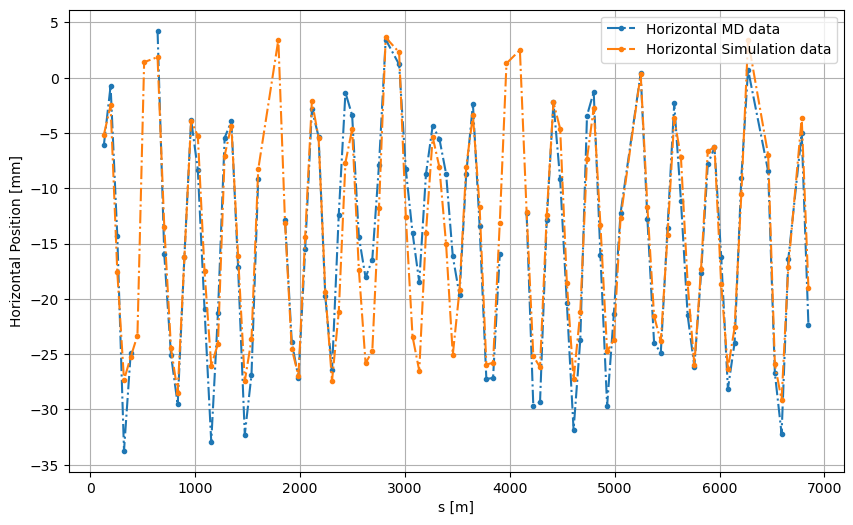

In [602]:
names_monitors = ak.Array([name.split('.')[0] + '.' + name.split('.')[1] for name in monitors])
mask_monitors = [True if name in bpm_orbit.bpms_hor[mask_bpm] else False for name in names_monitors]

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, -1], '.-.', label='Horizontal MD data')
#ax.plot(s_positions_bpms[mask_bpm], md_data.hor_turn_position[mask_bpm][:, 0], '.-.', label='Horizontal MD data first turn')
ax.plot(s_positions_monitors[mask_monitors], x_positions[4023][mask_monitors]*1e3, '.-.', label='Horizontal Simulation data')
ax.set_xlabel('s [m]')
ax.set_ylabel('Horizontal Position [mm]')
ax.grid()
ax.legend()

In [598]:
def moindre_carres(ref_data, sim_data, mask_None):
    distances = []
    for turn in range(len(sim_data)):
        distances.append(np.linalg.norm(sim_data[turn][~mask_None] - ref_data[~mask_None]))
    best_turn = np.nanargmin(distances)

    # distances = np.linalg.norm(sim_data - ref_data, axis=1)
    # best_turn = np.argmin(distances)
    return best_turn, distances

In [ ]:
mask_None = ak.is_none(md_data.hor_turn_position[mask_bpm][:, -1])
mask_ba3 = np.array([True if bpm.split('.')[1][0] == '3' else False for bpm in names_monitors[mask_None]])
moindre_carres(md_data.hor_turn_position[mask_bpm][:, -1], x_positions[:, mask_monitors]*1e3, mask_None )

ValueError: cannot broadcast RegularArray of size 5 with RegularArray of size 96 in bitwise_and

In [573]:
np.linalg.norm(x_positions[:, mask_monitors]*1e3 - md_data.hor_turn_position[mask_bpm][:, -1])

np.float64(nan)

In [614]:
len(mask_None)

96

In [618]:
md_data.hor_turn_position[mask_bpm][:, -1]

<Array [-6.08, -0.747, -14.3, ..., -16.4, -5.01, -22.4] type='96 * ?float64'>

In [574]:
x_positions[:, mask_monitors]*1e3 - md_data.hor_turn_position[mask_bpm][:, -1]

<Array [[8.8, 2.34, 10.9, ..., 7.73, 22.8], ...] type='7000 * 96 * ?float64'>

In [594]:
mask_None = ak.is_none(md_data.hor_turn_position[mask_bpm][:, -1])
md_data.hor_turn_position[mask_bpm][:, -1][~mask_None]

<Array [-6.08, -0.747, -14.3, ..., -16.4, -5.01, -22.4] type='91 * ?float64'>

In [604]:
names_monitors[0].split('.')[1][0]

'1'

In [596]:
x_positions[-1000][~mask_None]

<Array [-0.0315, -0.0095, -0.0043, ..., 0.00374, 0.00255] type='91 * float64'>

In [584]:
len(mask_None)

96

In [586]:
md_data.hor_turn_position[mask_bpm][:, -1][~mask_None]

<Array [-6.08, -0.747, -14.3, ..., -16.4, -5.01, -22.4] type='96 * ?float64'>

In [ ]:
mask_None = ak.is_none(md_data.hor_turn_position[mask_bpm][:, -1])

<Array [False, False, False, False, ..., False, False, False] type='96 * bool'>